In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
from datetime import datetime

# OpenAQ

In [2]:
import openaq

api = openaq.OpenAQ(version="v2")

In [3]:
# res = api.countries(limit=10000, df=True)

# res = api.parameters(df=True)

# res = api.locations(city='Delhi', parameter='pm25', df=True)

# res = api.cities(country="GR", limit=10000, df=True)

In [4]:
class Location:
    def __init__(self, name, lat, lon):
        self.name = name
        self.lat = lat
        self.lon = lon


locations_GR = []

cities = api.cities(country="GR", limit=100000, df=True)["city"]

for city in cities:
    print(city)
    res = api.locations(city=city, df=True)[["coordinates.latitude","coordinates.longitude"]].mean()
    
    locations_GR.append(Location(city, res["coordinates.latitude"], res["coordinates.longitude"]))

C:\Users\George\anaconda3\envs\tf-gpu\lib\site-packages\openaq\decorators.py:57: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  data = pd.io.json.json_normalize(resp)


ΑΤΤΙΚΗ
ΔΥΤΙΚΗ ΕΛΛΑΔΑ
ΘΕΣΣΑΛΙΑ
ΚΕΝΤΡΙΚΗ ΜΑΚΕΔΟΝΙΑ
ΣΤΕΡΕΑ ΕΛΛΑΔΑ


In [5]:
coordinates = "{},{}".format(round(locations_GR[0].lat, 8), round(locations_GR[0].lon, 8))

locations = api.locations(coordinates=coordinates, radius=20000,limit=100000, parameter="pm25", df=True, sort="asc")

In [6]:
locations["coordinates.latitude"].max(), locations["coordinates.longitude"].max()

(38.14352417, 23.8401)

In [49]:
from datetime import datetime, timedelta

date_from.date(), date_to.date()

# ΑΤΤΙΚΗ
selected_location = locations_GR[0]
coordinates = "{},{}".format(round(selected_location.lat, 8), round(selected_location.lon, 8))

now = datetime.now() + timedelta(days=1)

# For some reason the OpenAQ API accepts the date only in this way
date_from = datetime(now.year - 1 ,now.month,now.day - 1)
date_to = datetime(now.year, now.month, now.day)

print("Time Range: {} - {}".format(date_from, date_to))

# cities available data
# ΑΤΤΙΚΗ - ['pm25','pm10','o3''so2','co'],
# ΔΥΤΙΚΗ ΕΛΛΑΔΑ - ['pm25','pm10','so2','co','no2'],
# ΘΕΣΣΑΛΙΑ - ['pm25','pm10'],
# ΚΕΝΤΡΙΚΗ ΜΑΚΕΔΟΝΙΑ - ['pm25','pm10','no2','o3''so2','co']
# ΣΤΕΡΕΑ ΕΛΛΑΔΑ - ['pm25','pm10','so2','no2','o3']

selected_pollutants = ['pm25','pm10','o3','so2','co']

df_pollutants = pd.DataFrame(columns=['pm25','pm10','o3','so2','co'])

for pollutant in selected_pollutants:
    print('Setting up '+pollutant)
    
#   Get data with city key
    df_city = api.measurements(city=selected_location.name,
                               radius=20000,
                               date_from=date_from.date(), 
                               date_to=date_to.date(),
                               limit=100000, 
                               parameter=pollutant, 
                               df=True, 
                               sort="asc")[["value"]].resample('H').mean()
    
#   Get data with coordinate estimate
    df_coord = api.measurements(coordinates=coordinates,
                                radius=20000,
                                date_from=date_from.date(), 
                                date_to=date_to.date(),
                                limit=100000, 
                                parameter=pollutant, 
                                df=True, 
                                sort="asc")[["value"]].resample('H').mean()

#   Merge values
    df = df_city.merge(df_coord, how='outer', left_index=True, right_index=True, suffixes=('1', '2'))
    
    df_pollutants[pollutant] = df.mean(axis=1)
    df_pollutants[pollutant] = df_pollutants[pollutant].interpolate(method='time')

df_pollutants

Time Range: 2020-06-13 00:00:00-2021-06-14 00:00:00
Setting up pm25


Setting up pm10
Setting up o3
Setting up so2
Setting up co


,pm25,pm10,o3,so2,co
date.local,,,,,
2020-06-13 07:00:00,7.000000,12.700000,54.166667,7.333333,400.0
2020-06-13 08:00:00,9.333333,15.400000,49.833333,9.000000,550.0
2020-06-13 09:00:00,10.166667,17.100000,53.166667,11.666667,600.0
2020-06-13 10:00:00,8.666667,18.800000,63.833333,14.333333,550.0
2020-06-13 11:00:00,9.833333,17.300000,73.500000,15.000000,650.0
...,...,...,...,...,...
2021-06-13 08:00:00,11.750000,17.666667,40.111111,7.666667,775.0
2021-06-13 09:00:00,11.250000,18.333333,56.555556,8.333333,675.0
2021-06-13 10:00:00,12.750000,21.444444,73.666667,13.000000,525.0


<AxesSubplot:xlabel='date.local'>

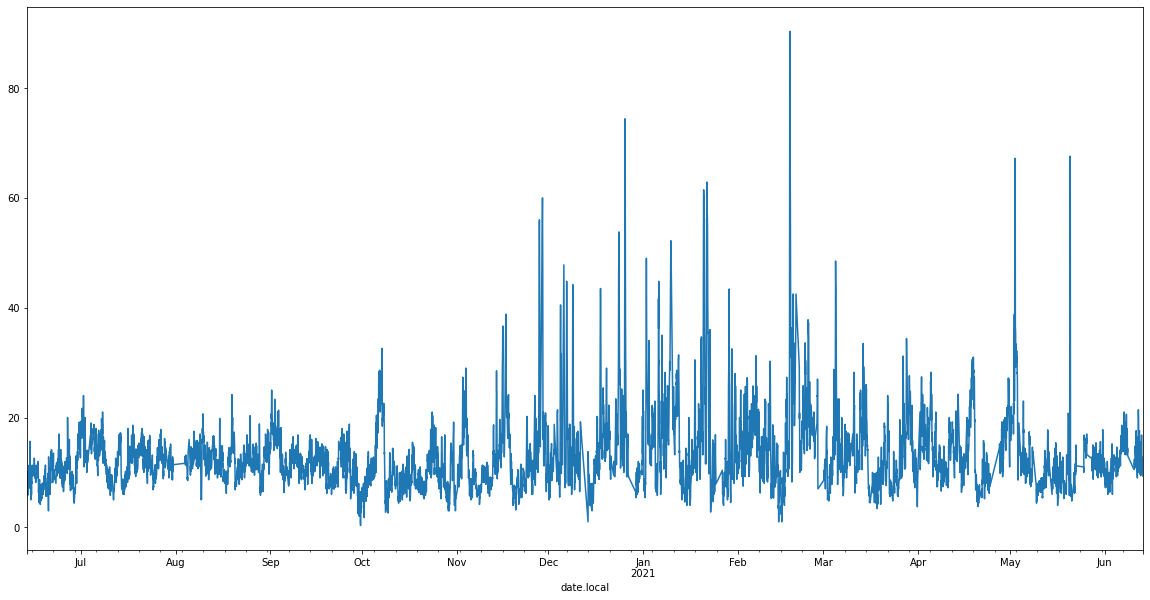

In [51]:
df_pollutants["pm25"].plot(figsize=(20,10))

In [52]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

trace1 = go.Scatter(x=df_pollutants.index,
                    y=df_pollutants["pm25"],
                    name = "plotly example",
                    line = dict(color = 'blue'),
                    opacity = 0.4)

layout = dict(title='plotly example',)

fig = dict(data=[trace1], layout=layout)
iplot(fig)

In [53]:
df_pollutants.isnull().sum()

pm25    0
pm10    0
o3      0
so2     0
co      0
dtype: int64

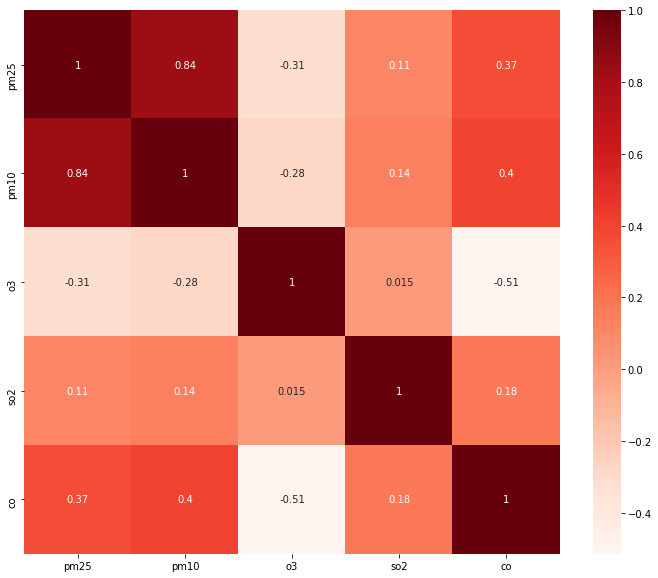

In [54]:
plt.figure(figsize=(12,10))
cor = df_pollutants.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Meteostat

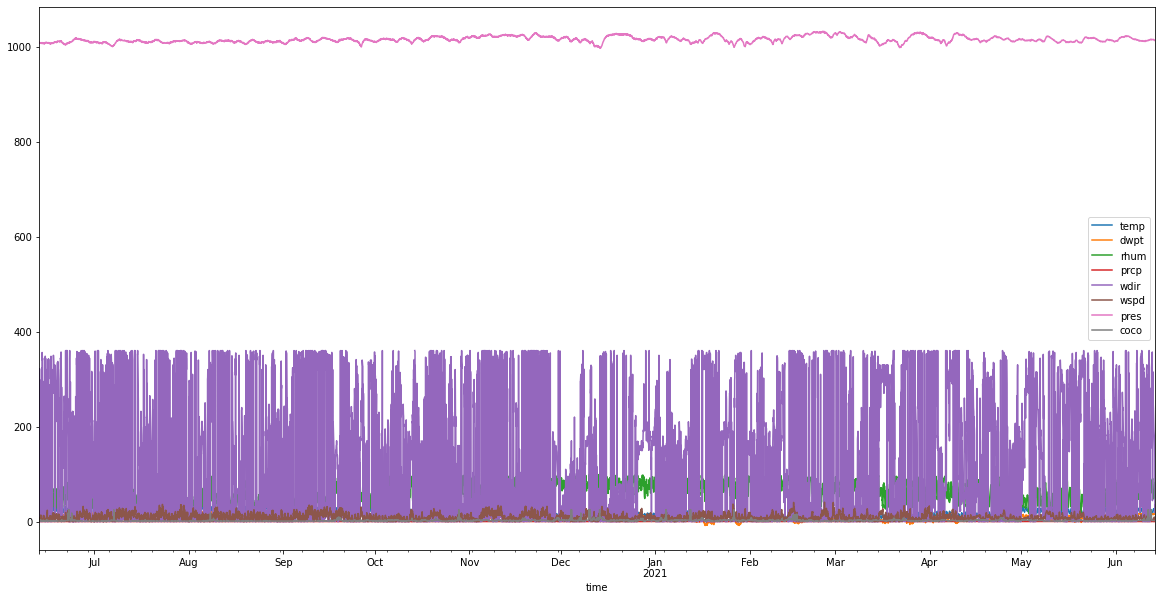

In [65]:
# Import Meteostat library and dependencies
from meteostat import Point, Hourly, Daily

# Create Point for Athens
athens = Point(selected_location.lat, selected_location.lon, 70)
athens

# temp	The air temperature in °C
# dwpt	The dew point in °C
# rhum	The relative humidity in percent (%)
# prcp	The one hour precipitation total in mm
# snow	The snow depth in mm
# wdir	The average wind direction in degrees (°)
# wspd	The average wind speed in km/h
# wpgt	The peak wind gust in km/h
# pres	The average sea-level air pressure in hPa
# tsun	The one hour sunshine total in minutes (m)
# coco	The weather condition code

# Get hourly data for 2021
df_weather = Hourly(loc=athens, start=date_from, end=date_to)
df_weather = df_weather.fetch()

# Remove columns that hold no values
df_weather.drop(['snow', 'wpgt', 'tsun'], axis=1, inplace=True)
# df_weather = df_weather.interpolate(method='time')

# Plot line chart including average, minimum and maximum temperature
df_weather.plot(figsize=(20,10))
plt.show()

In [107]:
from meteostat import Point, Hourly, units

# Create Point for Athens
athens = Point(selected_location.lat, selected_location.lon, 70)

df_weather = Hourly(loc=athens, start=date_from, end=date_to)
df_weather = df_weather.normalize()

df_weather = df_weather.fetch()

df_weather

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2020-06-13 00:00:00,17.8,13.6,77.1,0.0,NaN,0.0,1.1,NaN,1008.9,NaN,1.0
2020-06-13 01:00:00,19.6,12.6,64.3,0.0,NaN,294.0,3.7,NaN,1008.3,NaN,2.0
2020-06-13 02:00:00,19.3,12.7,65.6,0.0,NaN,286.0,1.8,NaN,1008.2,NaN,2.0
2020-06-13 03:00:00,17.5,13.5,78.3,0.0,NaN,350.0,2.3,NaN,1008.5,NaN,2.0
2020-06-13 04:00:00,20.7,12.5,59.7,0.0,NaN,337.0,5.5,9.3,1007.8,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-13 20:00:00,20.0,15.9,77.3,0.0,NaN,248.0,5.3,NaN,1013.3,NaN,2.0
2021-06-13 21:00:00,19.4,15.7,79.2,0.0,NaN,245.0,5.5,NaN,1013.1,NaN,2.0
2021-06-13 22:00:00,19.1,15.6,80.1,0.0,NaN,255.0,5.5,NaN,1013.0,NaN,1.0
